# <font color='steelblue'> Performance analysis using the position dataframe - timeouts removed from the pool
    
### I will repeat the performance analysis, now with after the removal of trials in which the rat did not express his choice before 15 seconds have elapsed from the start of the trial. During test illumination, the silencing of CG ends after 15 seconds after the illumination started. Therefore, we will only keep in our analysis the trials in which the rat expressed his choice during the first 15 seconds of the run, discarding the ones in which he did not (timeout trials). To determine wether the rat has expressed his choice before the 15 seconds has elapsed, we will calculate the latency until exiting the choice point ROI. Then, we will use this metric to remove the timeout trials and re-do our main performance analysis:
#### 1. Pooled performance during the illumination protocol;
#### 2. Session performances distribution during the illumination protocol;
#### 3. Non-illumination vs. Test illumination pooled performance across individuals;   
#### 4. Non-illumination vs. Sample illumination pooled performance across individuals; (I'M HERE!)
#### 5. Performance given experience within experimental groups;
#### 6. Performance given experience within illumination conditions.

### <font color='firebrick'> Imports

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from file_lists import get_file_list
%matplotlib inline
%run data_prep_functions.ipynb

### <font color='firebrick'> Input

In [117]:
path = "E:\POSITION DATA\PRE PROCESSED"

### <font color= 'seagreen'> Collect the pruned timestamped position and CP rois from all rats in the given path

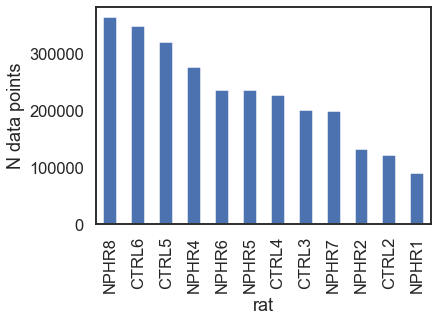

In [118]:
data, rois = collect_pruned_position_and_cp_rois_all_rats_in_path(path)
# Check if data from all rats are present in the dataframe
data['rat'].value_counts().plot.bar()
plt.xlabel('rat')
plt.ylabel('N data points')
plt.show()

### <font color='seagreen'> Collect only the data from test runs

In [160]:
test_runs_raw=data[data['run_type'] == 'T']
test_runs_raw['stim_condition'] =  test_runs_raw['stim_condition'].astype(int).astype(str)
test_runs_raw=test_runs_raw[test_runs_raw['stim_condition'] != '-1']
test_runs_raw.head()
len(test_runs_raw)

<ipython-input-160-10649a3b6b61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_runs_raw['stim_condition'] =  test_runs_raw['stim_condition'].astype(int).astype(str)


1061200

### <font color='seagreen'> Get ROI crossing timestamps: start of run, entry in cp, exit of cp and calculate the latency to CP exit

In [162]:
test_runs = get_roi_crossing_timestamps_for_runs_in_df(test_runs_raw, rois)
test_runs['latency_to_cp_exit'] = test_runs['cp_exit_timestamp'] - test_runs['start_timestamp']
test_runs.head(3)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_exit
0,2019-08-08T12_41_07,NPHR1,6.0,368.579635,T,1,1.0,NPHR,371.569088,372.640947,4.061312
1,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3,1.0,NPHR,755.435469,756.431386,4.913382
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,4.815962


### <font color='seagreen'> Remove runs without an expressed choice before 15 secs from the start have elapsed 

In [140]:
below15_test_runs = test_runs[test_runs['latency_to_cp_exit']<15]
below15_test_runs.head(3)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_exit
0,2019-08-08T12_41_07,NPHR1,6.0,368.579635,T,1,1.0,NPHR,371.569088,372.640947,4.061312
1,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3,1.0,NPHR,755.435469,756.431386,4.913382
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,4.815962


Proportion of kept runs (below 15sec until CP exit):0.9179304192685103


<AxesSubplot:xlabel='group', ylabel='run_nr'>

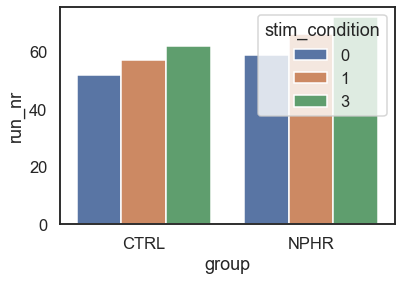

In [179]:
print('Proportion of kept runs (below 15sec until CP exit):{}'.format(len(below15_test_runs)/len(test_runs)))
below_runs_count = below15_test_runs.groupby(['group', 'stim_condition'])['run_nr'].count()
all_runs_count = test_runs.groupby(['group', 'stim_condition'])['run_nr'].count().rename({'run_nr':'all'})

<AxesSubplot:xlabel='group', ylabel='run_nr'>

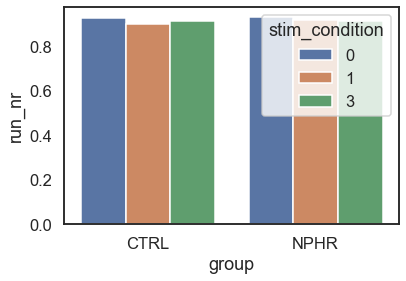

In [184]:
prop_kept_runs = below_runs_count/all_runs_count
sns.barplot(data=prop_kept_runs.reset_index(), x='group', hue='stim_condition', y='run_nr')

In [141]:
# Calculate performances for each rat, session and stimulation condition
session_perfs = below15_test_runs.groupby(['group','rat','session', 'stim_condition']).apply(calc_performance_in_group)
session_perfs = session_perfs.reset_index().rename(columns={0:'performance'})

,group,rat,session,stim_condition,performance
0,CTRL,CTRL2,2020-02-07T14_40_27,0,50.000000
1,CTRL,CTRL2,2020-02-07T14_40_27,3,71.428571
2,CTRL,CTRL2,2020-02-08T10_24_17,0,71.428571
3,CTRL,CTRL2,2020-02-08T10_24_17,3,100.000000
4,CTRL,CTRL2,2020-02-09T10_17_11,0,100.000000
...,...,...,...,...,...
513,NPHR,NPHR8,2020-12-07T15_25_21,1,100.000000
514,NPHR,NPHR8,2020-12-07T15_25_21,3,85.714286
515,NPHR,NPHR8,2020-12-08T13_06_15,0,100.000000
516,NPHR,NPHR8,2020-12-08T13_06_15,1,87.500000


# <font color='darkgreen'> 1. Combined performance per rat distribution given stimulation condition and group
***
   #### Calculation of the overall performance for each rat given the stimulation condition and the experimental group
   #### Compares the performance levels of each experimental group in each stimulation condition, across the protocol
***

In [142]:
pooled_perfs = session_perfs.groupby(['group', 'rat', 'stim_condition'])['performance'].mean().reset_index()
pooled_perfs.head(3)

,group,rat,stim_condition,performance
0,CTRL,CTRL2,0,79.553571
1,CTRL,CTRL2,3,80.688808
2,CTRL,CTRL3,0,81.851852


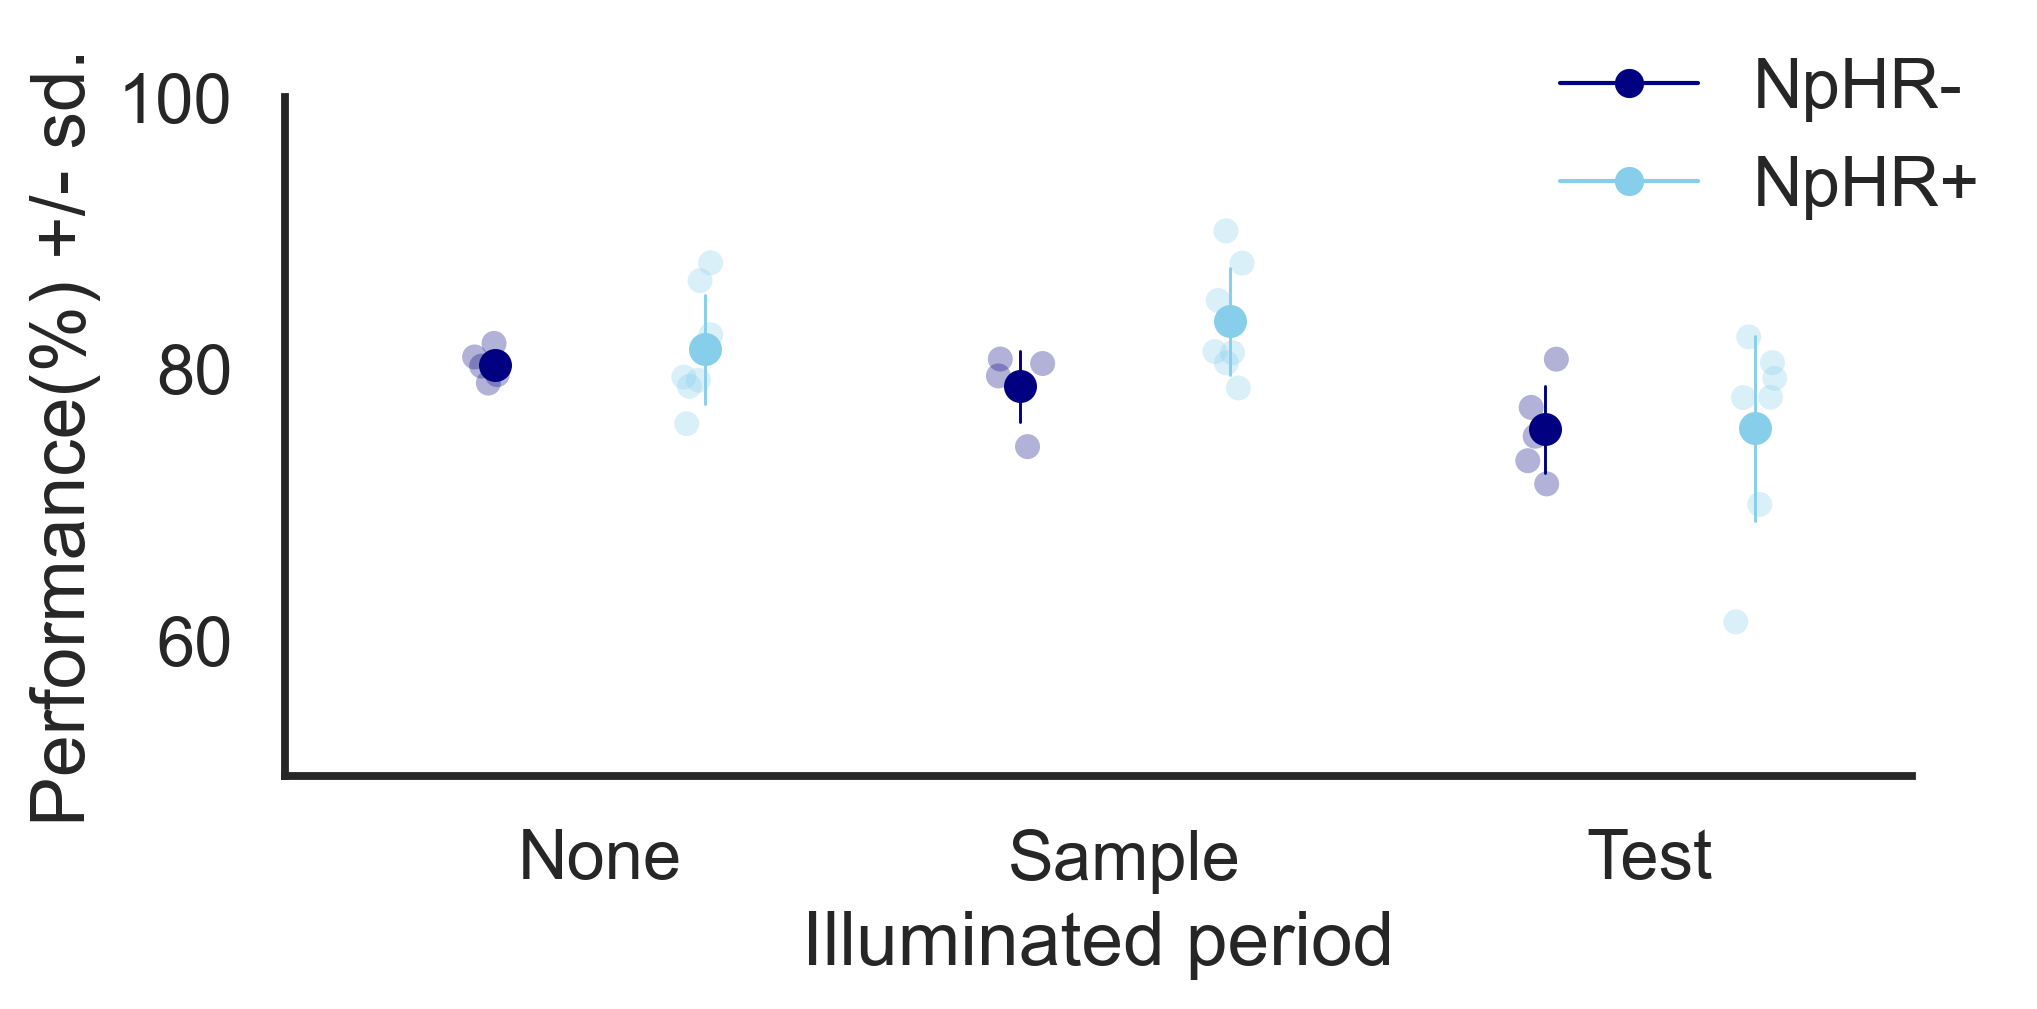

In [192]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(7,3),dpi=300)

g = sns.stripplot(
    x='stim_condition', y='performance', hue='group',
    data=pooled_perfs,
    dodge=2, jitter=.09,
    alpha=.3, s=6,
    palette=['navy', 'skyblue'],
    order=['0', '1', '3']
)

# Show means
sns.pointplot(
    x='stim_condition', y='performance', hue='group',
    data=pooled_perfs,
    dodge=.4, 
    join=False,            
    markers="o", scale=.6, linewidth=1.5,
    ci="sd",
    errwidth=.7,
    palette=['navy', 'skyblue'],
    order=['0','1', '3']
)

g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Illuminated period',
    ylim=(50, 100), xlim=(-0.6, 2.5)
)

g.set_xticklabels(labels=['None', 'Sample', 'Test'], rotation=0)

# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()

control_line = mlines.Line2D([], [], color='navy', marker='o', markersize=6, linewidth=1, label='NpHR-')
nphr_line = mlines.Line2D([], [], color='skyblue', marker='o', markersize=6, linewidth=1, label='NpHR+')
plt.legend(handles=[control_line, nphr_line], frameon=False, loc='upper right', bbox_to_anchor=(1.08, 1.15))
sns.despine()

# <font color='darkgreen'> 2. Session performances distribution during the illumination protocol
***
   #### Calculation of the performances for each session*rat given the stimulation condition and grouped by experimental group
   #### Compares the performance levels of each experimental group in each stimulation condition, across the protocol, at the session level
***

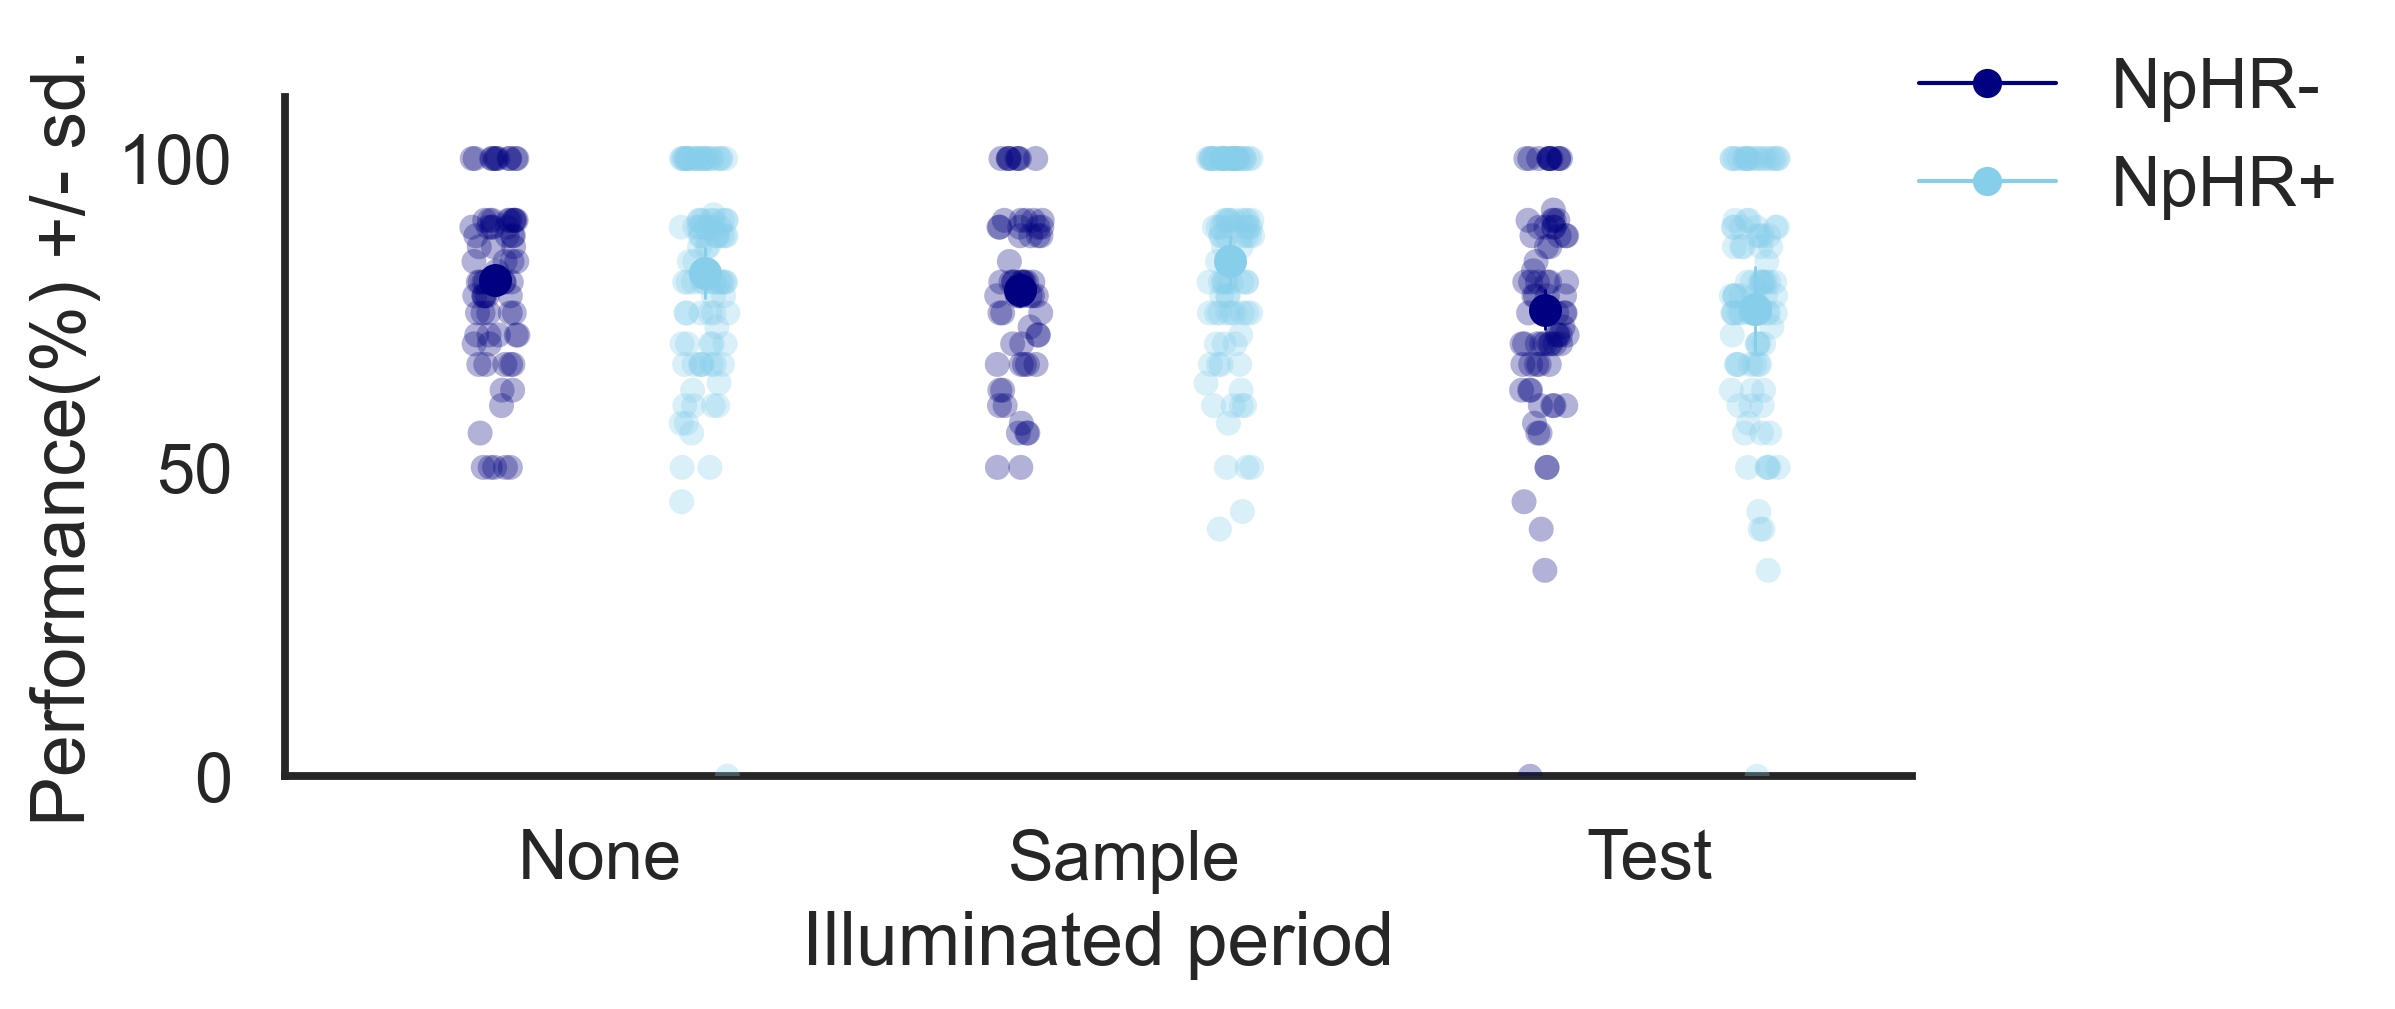

In [198]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(7,3),dpi=300)
# Remove 3 data points with performance = 0 (appeared after the removal of )
session_perfs = session_perfs[session_perfs['performance']=='0']
g = sns.stripplot(
    x='stim_condition', y='performance', hue='group',
    data=session_perfs,
    dodge=2, jitter=.09,
    alpha=.3, s=6,
    palette=['navy', 'skyblue'],
    order=['0', '1', '3']
)
# Show means
sns.pointplot(
    x='stim_condition', y='performance', hue='group',
    data=pooled_perfs,
    dodge=.4, 
    join=False,            
    markers="o", scale=.6, linewidth=1.5,
    ci="sd",
    errwidth=.7,
    palette=['navy', 'skyblue'],
    order=['0','1', '3']
)
g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Illuminated period',
    ylim=(0, 110), xlim=(-0.6, 2.5)
)
g.set_xticklabels(labels=['None', 'Sample', 'Test'], rotation=0)
# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()
control_line = mlines.Line2D([], [], color='navy', marker='o', markersize=6, linewidth=1, label='NpHR-')
nphr_line = mlines.Line2D([], [], color='skyblue', marker='o', markersize=6, linewidth=1, label='NpHR+')
plt.legend(handles=[control_line, nphr_line], frameon=False, loc='upper right', bbox_to_anchor=(1.3, 1.15))

sns.despine()

In [200]:
session_perfs[session_perfs['performance']==0]

,group,rat,session,stim_condition,performance
178,CTRL,CTRL6,2020-11-16T15_34_22,3,0.0
276,NPHR,NPHR2,2019-10-08T14_08_27,3,0.0
465,NPHR,NPHR7,2020-10-27T10_07_46,0,0.0


#### Some sessions (below) have a performance of zero. I checked these sessions and they are all small portions of larger sessions (for instance due to Bonsai crahes). Due to the low number of trials, it is easy for them to have performances of zero. 

# <font color='darkgreen'> 3. Non-illumination vs. Test illumination pooled performance across individuals; 
***
#### To better compare (visually) the performance under no illumination and test illumination across individuals from both groups.
***

In [207]:
mask = (pooled_perfs['stim_condition']=='0') | (pooled_perfs['stim_condition'] =='3')
no_vs_test = pooled_perfs[mask]

<Figure size 2700x1200 with 0 Axes>

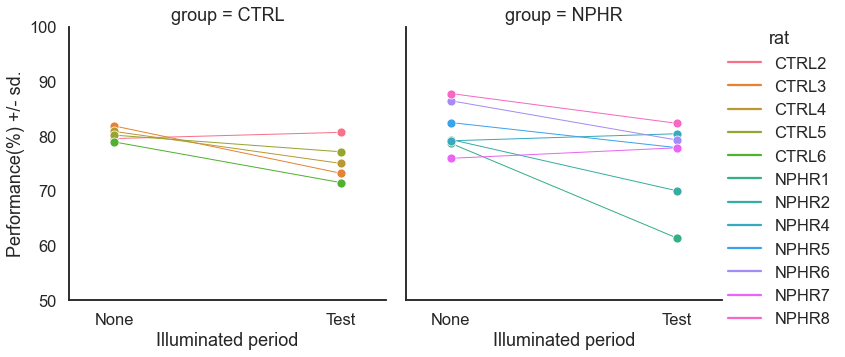

In [208]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(9,4),dpi=300)
g = sns.relplot(
    data=no_vs_test, col='group', height=5,
    x='stim_condition', y='performance', hue='rat', kind='line',
    linewidth=1, marker='o'
)
g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Illuminated period',
    ylim=(50, 100), xlim=(-0.2, 1.2), xticks=[0,1],
    xticklabels=['None', 'Test']
)